In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from lightgbm import LGBMClassifier
from lightgbm import early_stopping, log_evaluation


df = pd.read_csv("US_Accidents_March23.csv")

# Parse datetimes
for col in ["Start_Time", "End_Time", "Weather_Timestamp"]:
    df[col] = (
        df[col]
        .astype(str)
        .str.replace(r"\.000000000$", "", regex=True)
        .pipe(pd.to_datetime, format="%Y-%m-%d %H:%M:%S", errors="coerce")
    )

# Feature engineering
df["Start_Hour"]   = df["Start_Time"].dt.hour
df["Start_Day"]    = df["Start_Time"].dt.dayofweek
df["Start_Month"]  = df["Start_Time"].dt.month
df["Duration(min)"] = (df["End_Time"] - df["Start_Time"]).dt.total_seconds() / 60

# Define features
numeric_feats = [
    "Start_Lat", "Start_Lng", "End_Lat", "End_Lng",
    "Distance(mi)",
    "Temperature(F)", "Wind_Chill(F)", "Humidity(%)", "Pressure(in)",
    "Visibility(mi)", "Wind_Speed(mph)", "Precipitation(in)",
    "Start_Hour", "Start_Day", "Start_Month", "Duration(min)",
    # Booleans (will be treated as 0/1)
    "Amenity", "Bump", "Crossing", "Give_Way", "Junction", "No_Exit",
    "Railway", "Roundabout", "Station", "Stop",
    "Traffic_Calming", "Traffic_Signal", "Turning_Loop"
]

cat_feats = [
    "City", "County", "State", "Zipcode", "Country", "Timezone",
    "Airport_Code", "Wind_Direction", "Weather_Condition",
    "Sunrise_Sunset", "Civil_Twilight", "Nautical_Twilight",
    "Astronomical_Twilight"
]

features = numeric_feats + cat_feats
X = df[features]
y = df["Severity"]

# Train / validation / test split
X_temp, X_test,  y_temp,  y_test  = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)
# (0.25 of 0.8 gives 0.20 of original for validation)

# Preprocessing: ordinal‑encode categoricals
preprocessor = ColumnTransformer(
    [("ord", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
      cat_feats)],
    remainder="passthrough"
)

# Pipeline: LightGBM with multiclass objective
pipeline = Pipeline([
    ("preproc", preprocessor),
    ("lgbm", LGBMClassifier(
        objective="multiclass",
        num_class=4,
        n_estimators=1000,
        learning_rate=0.05,
        random_state=42,
        n_jobs=-1
    ))
])

# Preprocess training/validation/test sets manually
pipeline.named_steps["preproc"].fit(X_train)

X_train_proc = pipeline.named_steps["preproc"].transform(X_train)
X_val_proc   = pipeline.named_steps["preproc"].transform(X_val)
X_test_proc  = pipeline.named_steps["preproc"].transform(X_test)

# Train LightGBM with early stopping via callbacks
lgbm = pipeline.named_steps["lgbm"]
lgbm.fit(
    X_train_proc, y_train,
    eval_set=[(X_val_proc, y_val)],
    eval_metric="multi_logloss",                    # or "multi_error", etc.
    callbacks=[
        early_stopping(stopping_rounds=50),         # stop if no improvement
        log_evaluation(period=100)                  # print metrics every 100 rounds
    ]
)

# Predict on test set
y_pred = lgbm.predict(X_test_proc)

# Evaluate
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.129043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3776
[LightGBM] [Info] Number of data points in the train set: 4637036, number of used features: 40
[LightGBM] [Info] Start training from score -4.742506
[LightGBM] [Info] Start training from score -0.227315
[LightGBM] [Info] Start training from score -1.783047
[LightGBM] [Info] Start training from score -3.631062
Training until validation scores don't improve for 50 rounds
[100]	valid_0's multi_logloss: 0.350587
[200]	valid_0's multi_logloss: 0.332051
[300]	valid_0's multi_logloss: 0.32832
[400]	valid_0's multi_logloss: 0.319993
[500]	valid_0's multi_logloss: 0.315684
[600]	valid_0's multi_logloss: 0.312814
[700]	valid_0's multi_logloss: 0.309305
[800]	valid_0's multi_logloss: 0.307006
[900]	valid_0's multi_logloss: 0.30328
[1000]	val

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Classification Report:
               precision    recall  f1-score   support

           1       0.64      0.28      0.38     13473
           2       0.91      0.96      0.93   1231396
           3       0.76      0.68      0.72    259868
           4       0.64      0.21      0.31     40942

    accuracy                           0.88   1545679
   macro avg       0.74      0.53      0.59   1545679
weighted avg       0.87      0.88      0.87   1545679

Confusion Matrix:
 [[   3716    9192     550      15]
 [   1379 1176502   50687    2828]
 [    594   81800  175552    1922]
 [    161   28942    3302    8537]]


In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report

# Re‑initialize with balanced weights
model_bal = LGBMClassifier(
    objective="multiclass",
    num_class=4,
    n_estimators=1000,
    learning_rate=0.05,
    class_weight="balanced",   # balance the classes
    random_state=42,
    n_jobs=-1
)

# Fit on already‑preprocessed data
# (assuming X_train_proc, y_train, X_val_proc, y_val, X_test_proc exist)
model_bal.fit(
    X_train_proc, y_train,
    eval_set=[(X_val_proc, y_val)],
    eval_metric="multi_logloss",
    callbacks=[early_stopping(stopping_rounds=50)]
)

# Evaluate
y_pred_bal = model_bal.predict(X_test_proc)
print(classification_report(y_test, y_pred_bal))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.113854 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3776
[LightGBM] [Info] Number of data points in the train set: 4637036, number of used features: 40
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's multi_logloss: 0.635416


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

           1       0.14      0.94      0.24     13473
           2       0.98      0.68      0.80   1231396
           3       0.55      0.83      0.66    259868
           4       0.16      0.86      0.28     40942

    accuracy                           0.71   1545679
   macro avg       0.46      0.83      0.49   1545679
weighted avg       0.88      0.71      0.76   1545679



In [ ]:
import numpy as np
from sklearn.metrics import f1_score, classification_report

# Get the probability matrix on your test set
proba = model_bal.predict_proba(X_test_proc)

# Define a grid of thresholds to try for class 1 (index 0) and class 4 (index 3)
t1_grid = np.linspace(0.05, 0.50, 10)   # from 0.05 to 0.5 in 10 steps
t4_grid = np.linspace(0.05, 0.50, 10)

best_score = -1
best_t1 = best_t4 = None

# Grid‐search over (t1, t4)
for t1 in t1_grid:
    for t4 in t4_grid:
        # generate predictions under these thresholds
        preds = []
        for p in proba:
            if p[0] >= t1:
                preds.append(1)
            elif p[3] >= t4:
                preds.append(4)
            else:
                preds.append(np.argmax(p) + 1)  # default to highest‐prob class

        score = f1_score(y_test, preds, average="macro")
        if score > best_score:
            best_score = score
            best_t1, best_t4 = t1, t4

print(f"Best macro-F1 = {best_score:.4f} at t1 = {best_t1:.2f}, t4 = {best_t4:.2f}")

# Recompute and inspect the full report at those thresholds
preds_opt = []
for p in proba:
    if p[0] >= best_t1:
        preds_opt.append(1)
    elif p[3] >= best_t4:
        preds_opt.append(4)
    else:
        preds_opt.append(np.argmax(p) + 1)

print("\nClassification Report at optimal thresholds:")
print(classification_report(y_test, preds_opt))


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Best macro-F1 = 0.4948 at t1 = 0.50, t4 = 0.50

Classification Report at optimal thresholds:
              precision    recall  f1-score   support

           1       0.14      0.94      0.24     13473
           2       0.98      0.68      0.80   1231396
           3       0.55      0.83      0.66    259868
           4       0.16      0.86      0.28     40942

    accuracy                           0.71   1545679
   macro avg       0.46      0.83      0.49   1545679
weighted avg       0.88      0.71      0.76   1545679



In [ ]:
import numpy as np
from sklearn.metrics import f1_score

# 1a) get validation probabilities
proba_val = model_bal.predict_proba(X_val_proc)

# 1b) define a finer grid, say 0.01 to 0.3
t1_grid = np.linspace(0.01, 0.30, 30)   # for class 1 (index 0)
t4_grid = np.linspace(0.01, 0.30, 30)   # for class 4 (index 3)

best_score = -1
best_t1 = best_t4 = None

for t1 in t1_grid:
    for t4 in t4_grid:
        preds = []
        for p in proba_val:
            if p[0] >= t1:
                preds.append(1)
            elif p[3] >= t4:
                preds.append(4)
            else:
                preds.append(np.argmax(p) + 1)
        score = f1_score(y_val, preds, average="macro")
        if score > best_score:
            best_score = score
            best_t1, best_t4 = t1, t4

print(f"▶ Best val macro-F1 = {best_score:.4f} at t1 = {best_t1:.3f}, t4 = {best_t4:.3f}")


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


▶ Best val macro‑F1 = 0.4520 at t1 = 0.300, t4 = 0.300


In [9]:
# get test probabilities
proba_test = model_bal.predict_proba(X_test_proc)

# generate test preds with the chosen thresholds
preds_test = []
for p in proba_test:
    if p[0] >= best_t1:
        preds_test.append(1)
    elif p[3] >= best_t4:
        preds_test.append(4)
    else:
        preds_test.append(np.argmax(p) + 1)

from sklearn.metrics import classification_report
print("Test set report with tuned thresholds:")
print(classification_report(y_test, preds_test))


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Test set report with tuned thresholds:
              precision    recall  f1-score   support

           1       0.12      0.96      0.21     13473
           2       0.98      0.59      0.74   1231396
           3       0.56      0.79      0.65    259868
           4       0.12      0.92      0.21     40942

    accuracy                           0.64   1545679
   macro avg       0.44      0.82      0.45   1545679
weighted avg       0.88      0.64      0.71   1545679



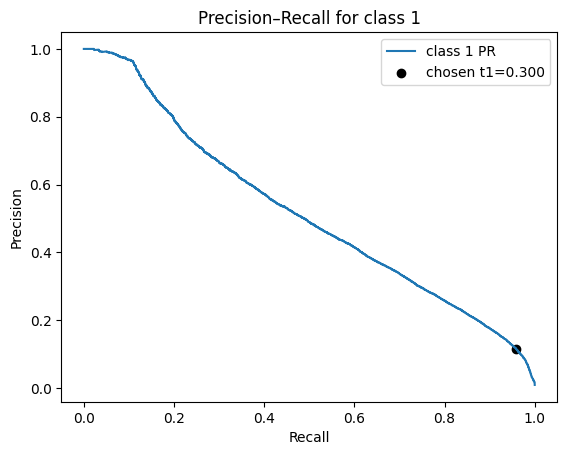

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# for class 1
prec1, rec1, thresh1 = precision_recall_curve(
    (y_val == 1).astype(int),
    proba_val[:,0]
)
plt.plot(rec1, prec1, label="class 1 PR")
# draw the chosen threshold
ix = np.argmin(np.abs(thresh1 - best_t1))
plt.scatter(rec1[ix], prec1[ix], marker='o', color='k',
            label=f"chosen t1={best_t1:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend()
plt.title("Precision-Recall for class 1")
plt.show()


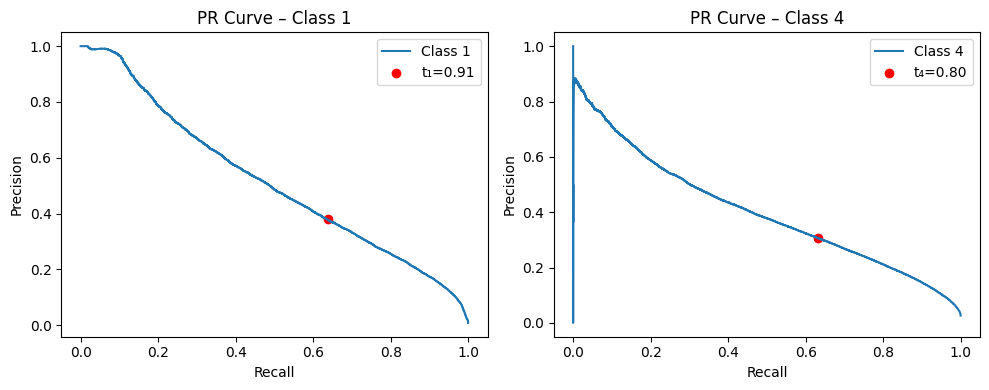

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

#    y_val (shape [n_val,]) and proba_val (shape [n_val, 4]) from the model

# Compute PR for class 1 and class 4
prec1, rec1, thr1 = precision_recall_curve((y_val==1).astype(int), proba_val[:,0])
prec4, rec4, thr4 = precision_recall_curve((y_val==4).astype(int), proba_val[:,3])

# Plot them side-by-side
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(rec1, prec1, label='Class 1')
ix1 = np.argmin(np.abs(thr1 - best_t1))
plt.scatter(rec1[ix1], prec1[ix1], color='red', label=f't₁={best_t1:.2f}')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('PR Curve – Class 1')
plt.legend()

plt.subplot(1,2,2)
plt.plot(rec4, prec4, label='Class 4')
ix4 = np.argmin(np.abs(thr4 - best_t4))
plt.scatter(rec4[ix4], prec4[ix4], color='red', label=f't₄={best_t4:.2f}')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('PR Curve – Class 4')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_curve, f1_score, classification_report

# Get validation probabilities
proba_val = model_bal.predict_proba(X_val_proc)

# Find the best threshold *for class 1* by maximizing F1₁ = 2·P·R/(P+R)
y_val_bin1 = (y_val == 1).astype(int)
prec1, rec1, thr1 = precision_recall_curve(y_val_bin1, proba_val[:, 0])
f1s1 = 2 * prec1 * rec1 / (prec1 + rec1 + 1e-8)
ix1 = np.argmax(f1s1)
best_t1 = thr1[ix1]
print(f"Best threshold for class 1 → t1 = {best_t1:.3f} (F1₁ = {f1s1[ix1]:.3f})")

# Find the best threshold *for class 4* in the same way
y_val_bin4 = (y_val == 4).astype(int)
prec4, rec4, thr4 = precision_recall_curve(y_val_bin4, proba_val[:, 3])
f1s4 = 2 * prec4 * rec4 / (prec4 + rec4 + 1e-8)
ix4 = np.argmax(f1s4)
best_t4 = thr4[ix4]
print(f"Best threshold for class 4 → t4 = {best_t4:.3f} (F1₄ = {f1s4[ix4]:.3f})")

# Apply these to the *test* set
proba_test = model_bal.predict_proba(X_test_proc)
preds = []
for p in proba_test:
    if p[0] >= best_t1:
        preds.append(1)
    elif p[3] >= best_t4:
        preds.append(4)
    else:
        preds.append(np.argmax(p) + 1)

print("\nTest classification report with per-class thresholds:")
print(classification_report(y_test, preds))


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Best threshold for class 1 → t1 = 0.917 (F1₁ = 0.496)
Best threshold for class 4 → t4 = 0.803 (F1₄ = 0.413)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



Test classification report with per‑class thresholds:
              precision    recall  f1-score   support

           1       0.14      0.94      0.24     13473
           2       0.98      0.68      0.80   1231396
           3       0.55      0.83      0.66    259868
           4       0.16      0.86      0.28     40942

    accuracy                           0.71   1545679
   macro avg       0.46      0.83      0.49   1545679
weighted avg       0.88      0.71      0.76   1545679



In [12]:
from sklearn.utils import resample
import numpy as np

# assume X_train_proc (n_samples × n_features) and y_train exist

# masks
mask1 = (y_train == 1)
mask4 = (y_train == 4)

# separate
X1, y1 = X_train_proc[mask1], y_train[mask1]
X4, y4 = X_train_proc[mask4], y_train[mask4]

# target count: 30% of majority (class 2) size
maj_count = (y_train == 2).sum()
n_up = int(0.3 * maj_count)

X1_up, y1_up = resample(X1, y1, replace=True,  n_samples=n_up, random_state=42)
X4_up, y4_up = resample(X4, y4, replace=True,  n_samples=n_up, random_state=42)

# combine
X_res = np.vstack([X_train_proc, X1_up, X4_up])
y_res = np.hstack([y_train,    y1_up, y4_up])


In [ ]:
from lightgbm import LGBMClassifier, early_stopping
import numpy as np
from sklearn.metrics import precision_recall_curve, f1_score, classification_report

# 2a) Define custom weights (milder than "balanced")
weights = {1: 2, 2: 1, 3: 1, 4: 2}

# 2b) Instantiate and fit on the resampled training data
model_custom = LGBMClassifier(
    objective="multiclass",
    num_class=4,
    n_estimators=1000,
    learning_rate=0.05,
    class_weight=weights,
    random_state=42,
    n_jobs=-1
)

model_custom.fit(
    X_res, y_res,
    eval_set=[(X_val_proc, y_val)],
    eval_metric="multi_logloss",
    callbacks=[early_stopping(stopping_rounds=50)]
)

# 2c) Per‑class threshold tuning on validation

# Get validation probs
proba_val = model_custom.predict_proba(X_val_proc)

# Class 1 PR curve → best t1
y_val_bin1 = (y_val == 1).astype(int)
prec1, rec1, thr1 = precision_recall_curve(y_val_bin1, proba_val[:, 0])
f1s1 = 2 * prec1 * rec1 / (prec1 + rec1 + 1e-8)
best_t1 = thr1[np.argmax(f1s1)]
print(f"New best t1 = {best_t1:.3f} with F1₁ = {np.max(f1s1):.3f}")

# Class 4 PR curve → best t4
y_val_bin4 = (y_val == 4).astype(int)
prec4, rec4, thr4 = precision_recall_curve(y_val_bin4, proba_val[:, 3])
f1s4 = 2 * prec4 * rec4 / (prec4 + rec4 + 1e-8)
best_t4 = thr4[np.argmax(f1s4)]
print(f"New best t4 = {best_t4:.3f} with F1₄ = {np.max(f1s4):.3f}")

# 2d) Evaluate on test set with these thresholds
proba_test = model_custom.predict_proba(X_test_proc)
preds = []
for p in proba_test:
    if p[0] >= best_t1:
        preds.append(1)
    elif p[3] >= best_t4:
        preds.append(4)
    else:
        preds.append(np.argmax(p) + 1)

print("\nTest set report after custom weights + threshold tuning:")
print(classification_report(y_test, preds))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.147713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3780
[LightGBM] [Info] Number of data points in the train set: 6853548, number of used features: 40
[LightGBM] [Info] Start training from score -1.391060
[LightGBM] [Info] Start training from score -0.916056
[LightGBM] [Info] Start training from score -2.471789
[LightGBM] [Info] Start training from score -1.321777
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's multi_logloss: 0.525661


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


New best t1 = 0.914 with F1₁ = 0.505
New best t4 = 0.801 with F1₄ = 0.433


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



Test set report after custom weights + threshold tuning:
              precision    recall  f1-score   support

           1       0.14      0.95      0.24     13473
           2       0.93      0.81      0.87   1231396
           3       0.75      0.58      0.65    259868
           4       0.19      0.84      0.30     40942

    accuracy                           0.77   1545679
   macro avg       0.50      0.79      0.52   1545679
weighted avg       0.88      0.77      0.81   1545679



In [ ]:
import numpy as np
import pandas as pd
from sklearn.utils import resample
from sklearn.metrics import precision_recall_curve, f1_score, classification_report
from lightgbm import LGBMClassifier, early_stopping

# prepare containers
results = []

# define custom class weight
weights = {1: 2, 2: 1, 3: 1, 4: 2}

# majority‐class count
maj_count = (y_train == 2).sum()

for ratio in [0.1, 0.2, 0.3, 0.4, 0.5]:
    # 1) oversample 1 & 4 to `ratio * maj_count`
    n_up = int(ratio * maj_count)
    X1, y1 = X_train_proc[y_train==1], y_train[y_train==1]
    X4, y4 = X_train_proc[y_train==4], y_train[y_train==4]
    X1_up, y1_up = resample(X1, y1, replace=True, n_samples=n_up, random_state=42)
    X4_up, y4_up = resample(X4, y4, replace=True, n_samples=n_up, random_state=42)
    X_res = np.vstack([X_train_proc, X1_up, X4_up])
    y_res = np.hstack([y_train,    y1_up, y4_up])

    # 2) train with custom weights + early stopping
    model = LGBMClassifier(
        objective="multiclass", num_class=4,
        n_estimators=1000, learning_rate=0.05,
        class_weight=weights, random_state=42, n_jobs=-1
    )
    model.fit(
        X_res, y_res,
        eval_set=[(X_val_proc, y_val)],
        eval_metric="multi_logloss",
        callbacks=[early_stopping(stopping_rounds=50)]
    )

    # 3) find best per‑class thresholds on VAL
    proba_val = model.predict_proba(X_val_proc)
    def find_thr(idx, y_val):
        prec, rec, thr = precision_recall_curve((y_val==idx+1).astype(int), proba_val[:,idx])
        f1s = 2*prec*rec/(prec+rec+1e-8)
        return thr[np.argmax(f1s)]
    t1 = find_thr(0, y_val)
    t4 = find_thr(3, y_val)

    # 4) eval on TEST with those thresholds
    proba_test = model.predict_proba(X_test_proc)
    preds = []
    for p in proba_test:
        if p[0]>=t1:       preds.append(1)
        elif p[3]>=t4:     preds.append(4)
        else:               preds.append(np.argmax(p)+1)
    macro_f1 = f1_score(y_test, preds, average="macro")
    
    results.append((ratio, t1, t4, macro_f1))

# summarize
df_res = pd.DataFrame(results, columns=["oversample_ratio","t1","t4","macro_f1"])
print(df_res.sort_values("macro_f1", ascending=False))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.173020 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3770
[LightGBM] [Info] Number of data points in the train set: 5375872, number of used features: 40
[LightGBM] [Info] Start training from score -2.035890
[LightGBM] [Info] Start training from score -0.530283
[LightGBM] [Info] Start training from score -2.086016
[LightGBM] [Info] Start training from score -1.852678
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's multi_logloss: 0.396783


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.198724 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3764
[LightGBM] [Info] Number of data points in the train set: 6114710, number of used features: 40
[LightGBM] [Info] Start training from score -1.604686
[LightGBM] [Info] Start training from score -0.741658
[LightGBM] [Info] Start training from score -2.297391
[LightGBM] [Info] Start training from score -1.504163
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's multi_logloss: 0.470766


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.283228 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3780
[LightGBM] [Info] Number of data points in the train set: 6853548, number of used features: 40
[LightGBM] [Info] Start training from score -1.391060
[LightGBM] [Info] Start training from score -0.916056
[LightGBM] [Info] Start training from score -2.471789
[LightGBM] [Info] Start training from score -1.321777
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's multi_logloss: 0.525661


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.323622 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3769
[LightGBM] [Info] Number of data points in the train set: 7592386, number of used features: 40
[LightGBM] [Info] Start training from score -1.260666
[LightGBM] [Info] Start training from score -1.064509
[LightGBM] [Info] Start training from score -2.620241
[LightGBM] [Info] Start training from score -1.207806
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's multi_logloss: 0.571988


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.459085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3774
[LightGBM] [Info] Number of data points in the train set: 8331224, number of used features: 40
[LightGBM] [Info] Start training from score -1.172098
[LightGBM] [Info] Start training from score -1.193745
[LightGBM] [Info] Start training from score -2.749478
[LightGBM] [Info] Start training from score -1.129366
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's multi_logloss: 0.611954


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   oversample_ratio        t1        t4  macro_f1
0               0.1  0.831461  0.645784  0.575433
1               0.2  0.886227  0.731112  0.536238
2               0.3  0.914328  0.800854  0.515320
3               0.4  0.933115  0.840750  0.498974
4               0.5  0.940227  0.857179  0.488574


In [ ]:
from lightgbm import LGBMClassifier, early_stopping
from sklearn.metrics import classification_report

# Re‑prepare the resampled training data at 10%
maj_count = (y_train == 2).sum()
n_up = int(0.1 * maj_count)
X1, y1 = X_train_proc[y_train==1], y_train[y_train==1]
X4, y4 = X_train_proc[y_train==4], y_train[y_train==4]
X1_up, y1_up = resample(X1, y1, replace=True, n_samples=n_up, random_state=42)
X4_up, y4_up = resample(X4, y4, replace=True, n_samples=n_up, random_state=42)
X_res = np.vstack([X_train_proc, X1_up, X4_up])
y_res = np.hstack([y_train, y1_up, y4_up])

# Train final model
final_model = LGBMClassifier(
    objective="multiclass", num_class=4,
    n_estimators=1000, learning_rate=0.05,
    class_weight={1:2,2:1,3:1,4:2},
    random_state=42, n_jobs=-1
)
final_model.fit(
    X_res, y_res,
    eval_set=[(X_val_proc, y_val)],
    eval_metric="multi_logloss",
    callbacks=[early_stopping(stopping_rounds=50)]
)

# Predict with tuned thresholds
proba_test = final_model.predict_proba(X_test_proc)
preds = [
    1 if p[0]>=0.83146 else
    4 if p[3]>=0.64578 else
    (p.argmax()+1)
    for p in proba_test
]

# Print report
print(classification_report(y_test, preds))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.128386 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3770
[LightGBM] [Info] Number of data points in the train set: 5375872, number of used features: 40
[LightGBM] [Info] Start training from score -2.035890
[LightGBM] [Info] Start training from score -0.530283
[LightGBM] [Info] Start training from score -2.086016
[LightGBM] [Info] Start training from score -1.852678
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's multi_logloss: 0.396783


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

           1       0.20      0.88      0.33     13473
           2       0.93      0.88      0.90   1231396
           3       0.77      0.62      0.68    259868
           4       0.27      0.69      0.39     40942

    accuracy                           0.83   1545679
   macro avg       0.54      0.77      0.58   1545679
weighted avg       0.88      0.83      0.85   1545679

